In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OPENBLAS_NUM_THREADS'] = '8'  # noqa, must go before jax

import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from collections import defaultdict
from tqdm import tqdm
import pandas as pd

In [2]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

wdir = '/home/mattho/git/ltu-cmass/data'

/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Observed

In [3]:
dirpath = join(wdir, 'cmass_ngc/cmass/L0-N0/0')

crdz = np.load(join(dirpath, 'obs/rdz0.npy'))
cw = np.load(join(dirpath, 'obs/rdz0_survey_weight.npy'))
cPk = np.load(join(dirpath, 'Pk/Pk0.npz'))

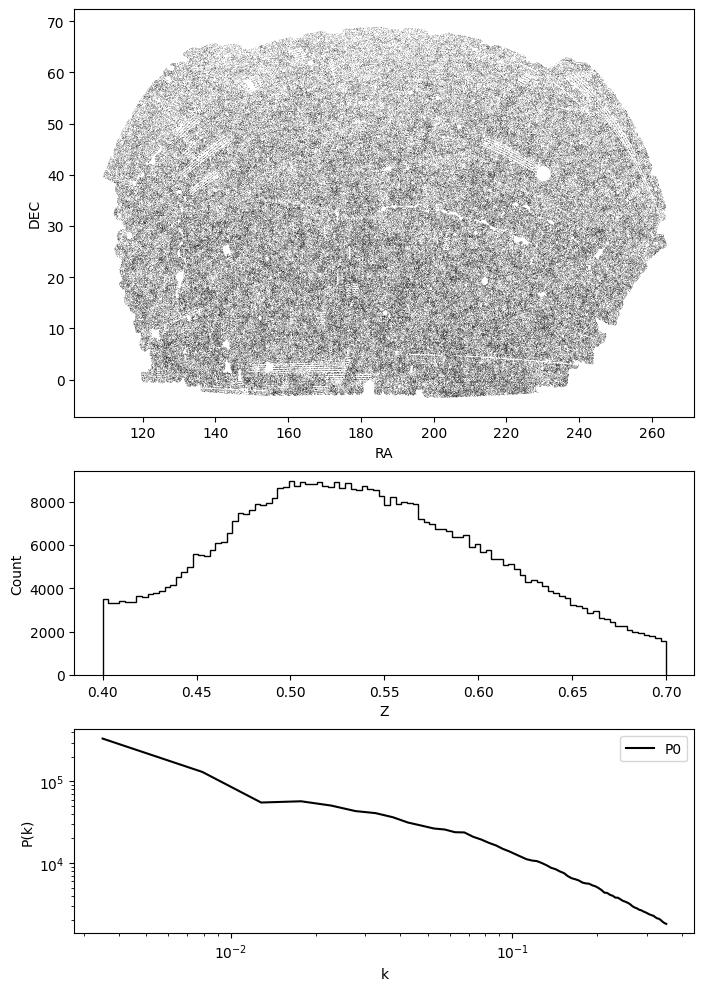

In [4]:
f, axs = plt.subplots(3,1, figsize=(8,12), gridspec_kw={'height_ratios': [0.6,0.3, 0.3]})

axs[0].plot(crdz[:,0], crdz[:,1], 'k,', alpha=0.1)
axs[0].set(xlabel='RA', ylabel='DEC')

axs[1].hist(crdz[:,2], bins=100, histtype='step', color='k');
axs[1].set(xlabel='Z', ylabel='Count')

axs[2].loglog()
axs[2].plot(cPk['k_gal'], cPk['p0k_gal'], 'k-', label='P0')
axs[2].set(xlabel='k', ylabel='P(k)')
axs[2].legend()

## Load Simulations

In [5]:

path_to_suite = join(wdir, 'inf_3gpch', 'borgpm', 'L3000-N384')

lhids = []
Pks = []
for d in os.listdir(path_to_suite):
    Pk_dir = join(path_to_suite, d, 'Pk')
    if not os.path.exists(Pk_dir):
        continue
    filename = join(Pk_dir, 'Pk0.npz')
    if not os.path.exists(filename):
        continue
    lhids.append(int(d))
    Pks.append(np.load(filename))
print(f'Found {len(lhids)} Pk files')

Found 1987 Pk files


In [6]:
kmin = 0.2  # kmin cut


ks = np.stack([Pk['k_gal'] for Pk in Pks])
Pk0 = np.stack([Pk['p0k_gal'] for Pk in Pks])
Pk2 = np.stack([Pk['p2k_gal'] for Pk in Pks])
Pk4 = np.stack([Pk['p4k_gal'] for Pk in Pks])

# sim
mask = ks[0] > kmin
ks = ks[:, mask]
Pk0 = Pk0[:, mask]
Pk2 = Pk2[:, mask]
Pk4 = Pk4[:, mask]

# obs
mask = cPk['k_gal'] > kmin
cks = cPk['k_gal'][mask]
cPk0 = cPk['p0k_gal'][mask]
cPk2 = cPk['p2k_gal'][mask]
cPk4 = cPk['p4k_gal'][mask]


In [7]:
lhpath = join('../params', 'latin_hypercube_params.txt')
lhdict = pd.read_csv(
    lhpath, delimiter=' ', header=None, 
    names=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8'])
lhdict = lhdict.iloc[lhids].reset_index(drop=True)
lhdict

,Omega_m,Omega_b,h,n_s,sigma_8
0,0.1867,0.04503,0.6189,0.8307,0.7187
1,0.3271,0.06875,0.6313,0.8135,0.8939
2,0.1755,0.06681,0.7737,0.8849,0.6641
3,0.2139,0.05557,0.8599,0.9785,0.8619
4,0.4791,0.06759,0.8131,0.9573,0.7391
...,...,...,...,...,...
1982,0.4425,0.03437,0.6909,1.1947,0.7035
1983,0.4945,0.06513,0.6117,1.1905,0.6043
1984,0.4017,0.04425,0.8509,0.8251,0.7833
1985,0.2709,0.03631,0.7531,1.0373,0.8325


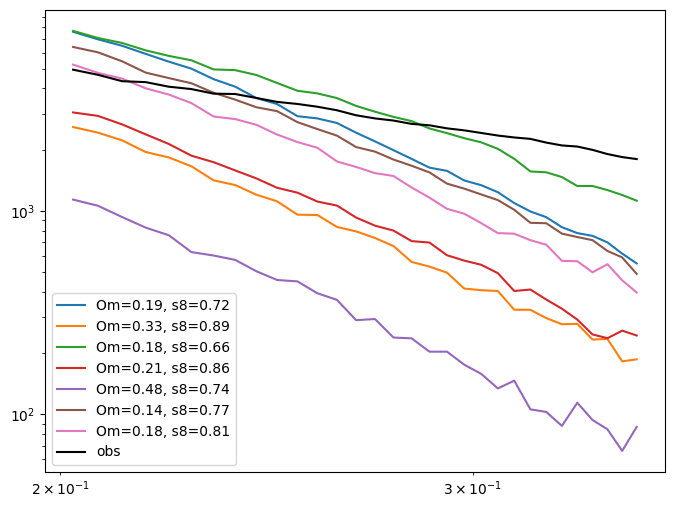

In [8]:

f, ax = plt.subplots(1,1, figsize=(8,6))
ax.loglog()
for i in range(7):
    ax.plot(ks[i], Pk0[i], label=f'Om={lhdict.Omega_m[i]:.2f}, s8={lhdict.sigma_8[i]:.2f}')
ax.plot(cks, cPk0, 'k-', label='obs')
ax.legend()

## Train one model

In [9]:
# make a dataloader
x = Pk0
theta = lhdict.values

loader = NumpyLoader(x=x, theta=theta)

In [10]:
lhmin = lhdict.min().values
lhmax = lhdict.max().values
lhmin, lhmax

(array([0.1001 , 0.03001, 0.5001 , 0.8001 , 0.6001 ]),
 array([0.4999 , 0.06999, 0.8999 , 1.1999 , 0.9999 ]))

In [11]:
lhmin = lhdict.min().values
lhmax = lhdict.max().values

# define a prior
prior = ili.utils.Uniform(low=lhmin, high=lhmax)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NLE', model='maf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NLE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-5
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NLE',
    prior=prior,
    nets=nets,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [12]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NLE
INFO:root:Training model 1 / 2.


 Neural network successfully converged after 512 epochs.

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 262

/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 558.2603929042816 seconds to train models.


 Neural network successfully converged after 263 epochs.

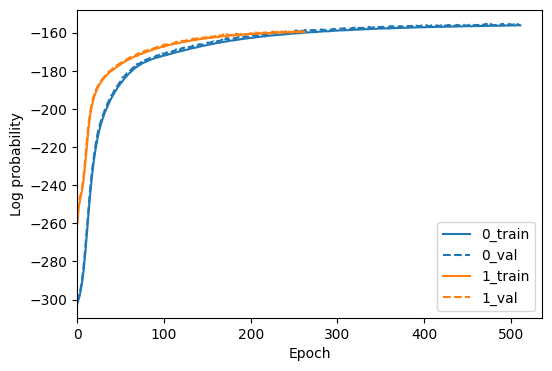

In [13]:

# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = [f'C{i}' for i in range(len(nets))]
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [14]:
# ind = np.random.randint(0, len(x))
# x_obs = x[ind]
x_obs = cPk0

Running vectorized MCMC with 10 chains: 100%|█████████▉| 10200/10230 [00:59<00:00, 172.16it/s]


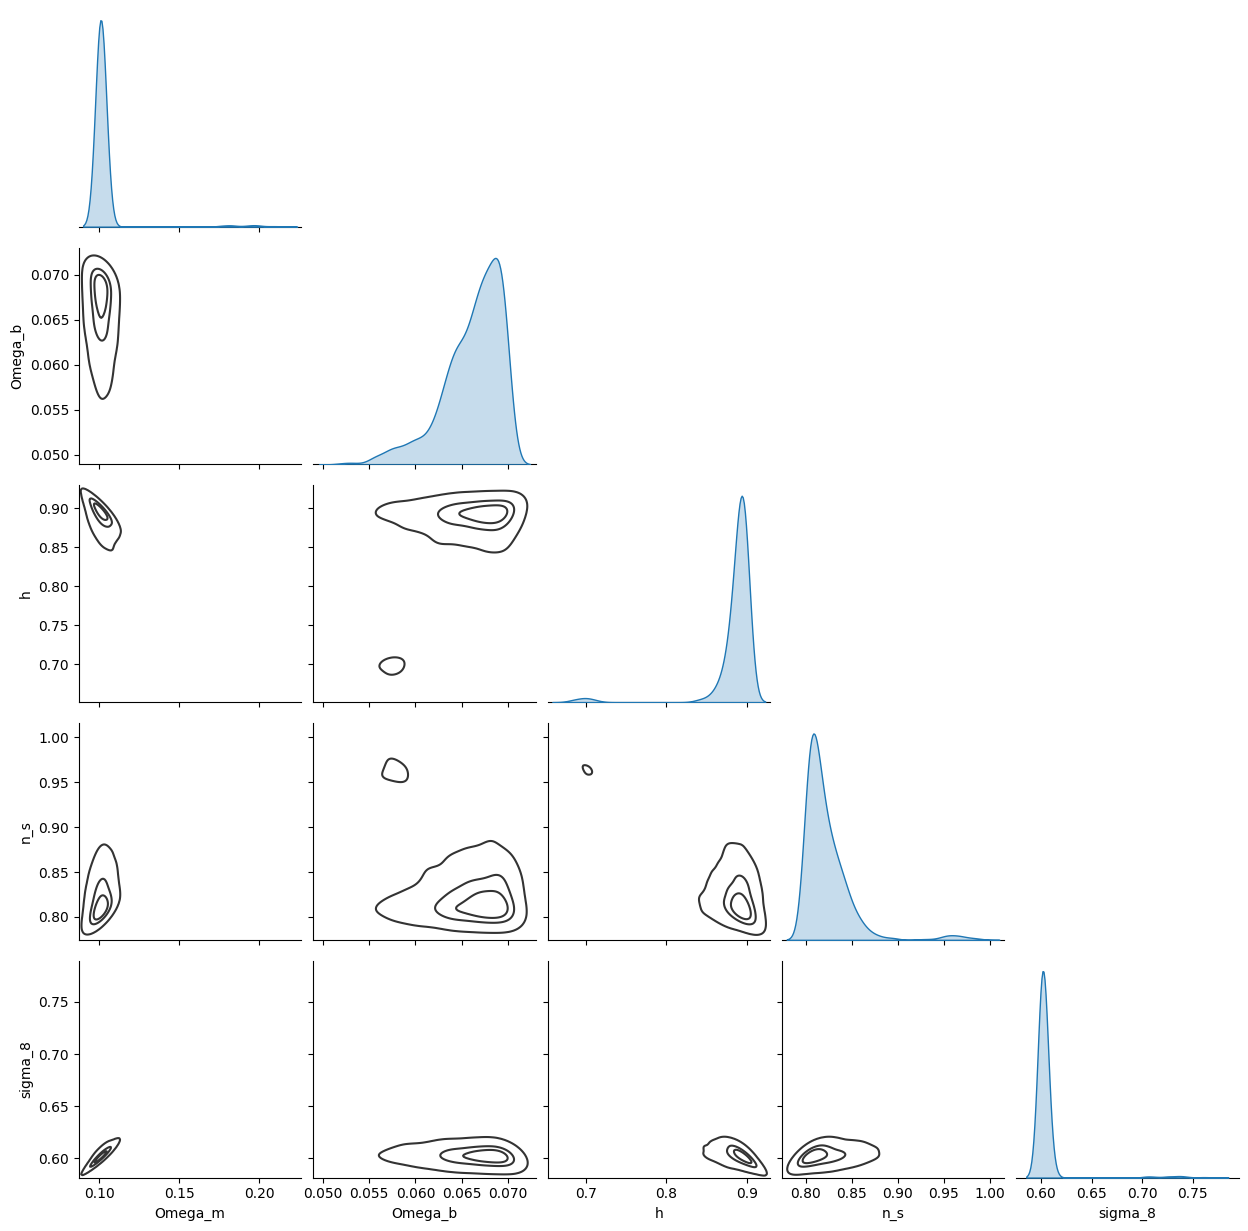

In [15]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, 
    sample_method='slice_np_vectorized', sample_params={'num_chains': 10},
    labels=lhdict.columns
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x_obs, # theta_fid=theta[ind]
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 231.40it/s]


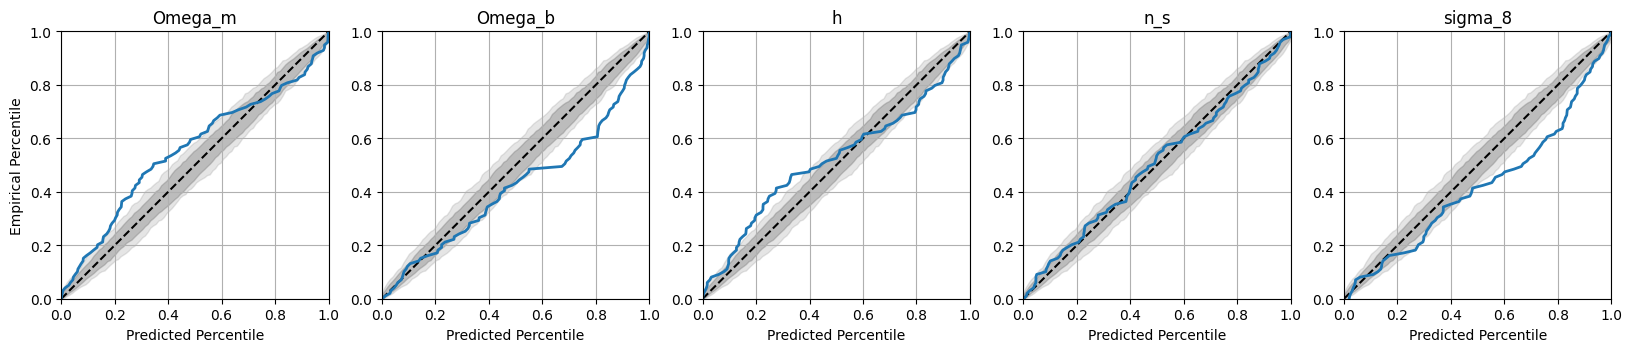

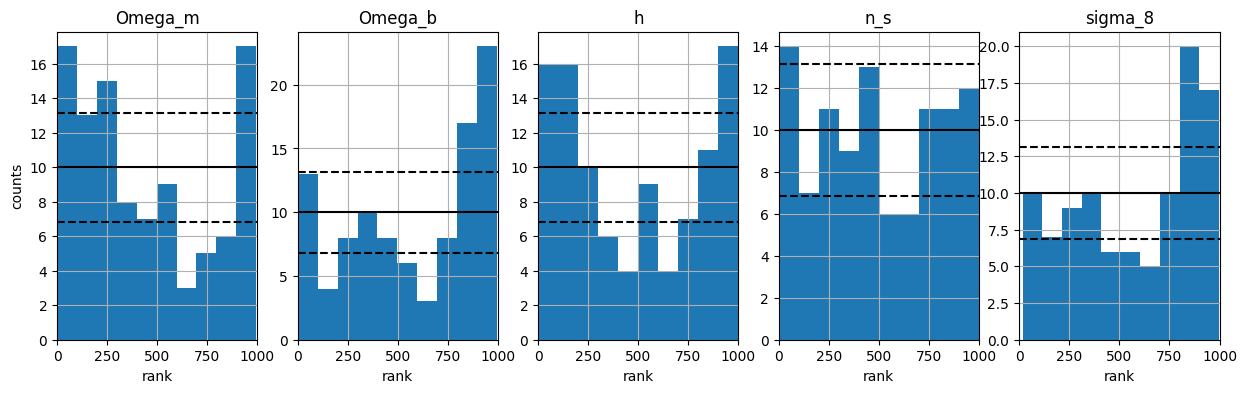

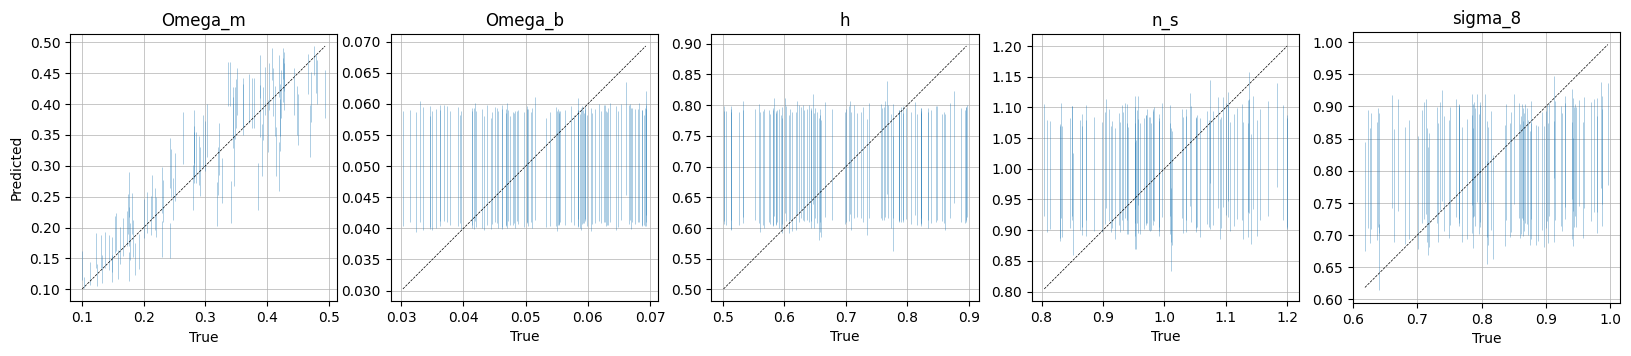

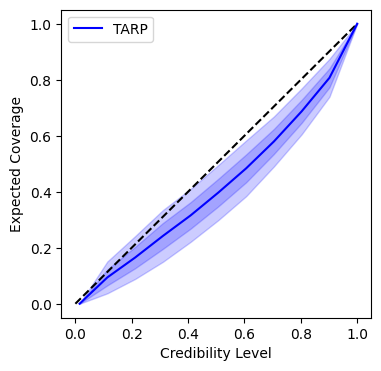

In [17]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=lhdict.columns,
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x[:100], theta=theta[:100]
)